<a href="https://colab.research.google.com/github/KantilalRane/realtime-face-recognition/blob/main/OkStoreModelAndDisplayDataAllSampleBrainDatabaseKANSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#############1111111ok##########
!pip install hdf5storage
!git clone https://github.com/adityajn105/brain-tumor-segmentation-unet
!bash brain-tumor-segmentation-unet/download_data.sh
!python brain-tumor-segmentation-unet/mat_to_numpy.py brain_tumor_dataset/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 6.3 MB/s eta 0:00:00
Cloning into 'brain-tumor-segmentation-unet'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 37 (delta 3), reused 2 (delta 2), pack-reused 32 (from 1)
Receiving objects: 100% (37/37), 1.21 MiB | 2.80 MiB/s, done.
Resolving deltas: 100% (6/6), done.
3064
/content/brain-tumor-segmentation-unet/mat_to_numpy.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(int(mat_file[0]))
[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in brain_tumor_dataset/


Labels shape: (3064,)
Images shape: (3064, 512, 512)
Masks shape: (3064, 512, 512)


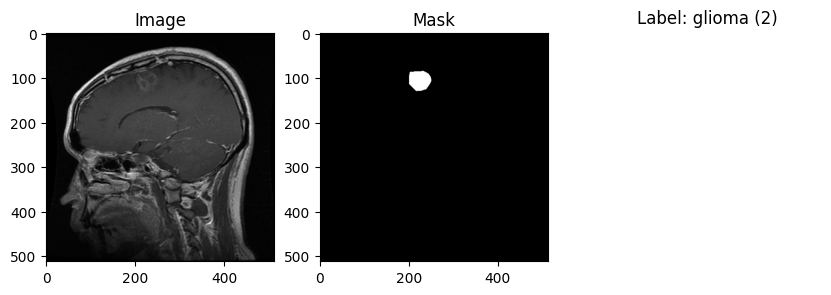

(3064, 128, 128, 1)
(3064, 128, 128, 1)
[ 708 1426  930]


((4902, 128, 128, 1), (4902, 128, 128, 1))

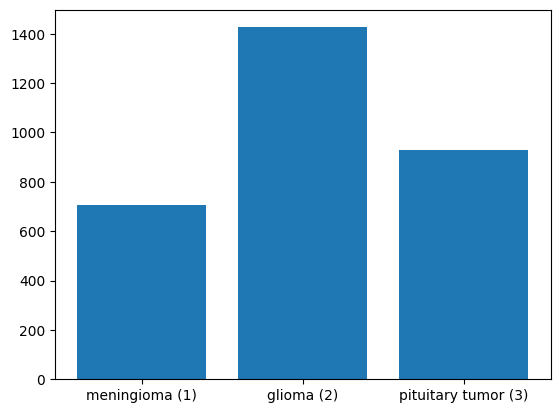

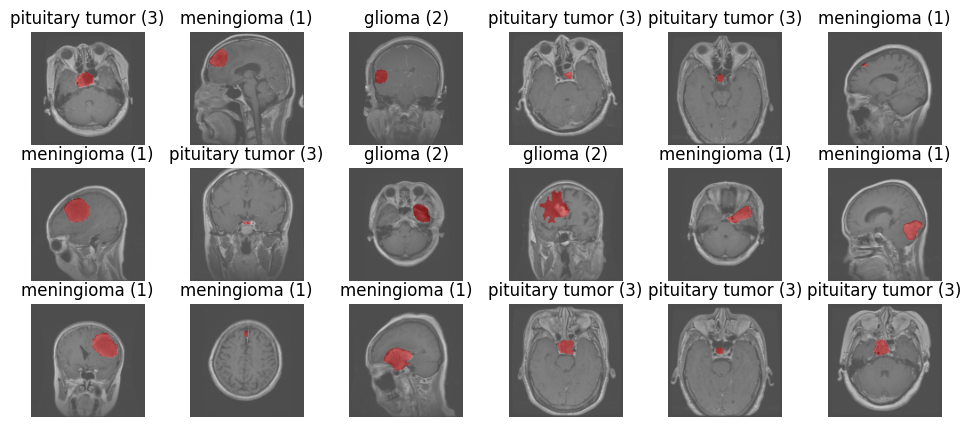

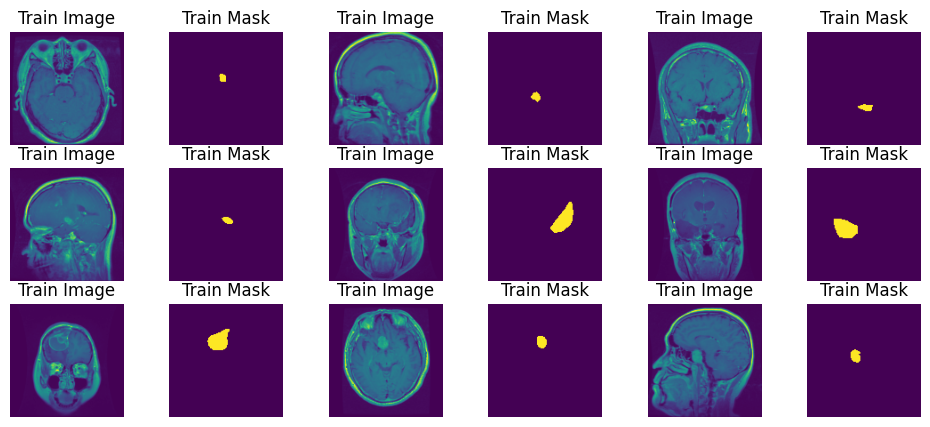

In [ ]:
#############1111111-111111111111ok##########
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

# Load data using memory mapping (no full load into RAM)
labels = np.load('brain_tumor_dataset/labels.npy', mmap_mode='r')
images = np.load('brain_tumor_dataset/images.npy', mmap_mode='r')
masks = np.load('brain_tumor_dataset/masks.npy', mmap_mode='r')

# Print shapes (only metadata, no RAM use)
print("Labels shape:", labels.shape)
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

# Example: Access and process only one image/mask/label to avoid memory spike
index = 0  # change index as needed

# Access one sample safely
image = np.clip(images[index] / 12728.0, 0, 1)
mask = masks[index] * 1  # safe for a single slice
label = labels[index]

# Display the sample
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title(f"Label: {integer_to_class[str(label)]}")
plt.show()

from skimage.transform import resize
img_size_ori = 512
img_size_target = 128

images = np.expand_dims(images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

images = np.array([ downsample(image) for image in images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

print(images.shape)
print(masks.shape)


classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(images[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(masks[idx])-masks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( images.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(images[idx],axis=-1))
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(masks[idx],axis=-1))
  plt.title("Train Mask")
  plt.axis('off')

from sklearn.model_selection import train_test_split
import gc
X,X_v,Y,Y_v = train_test_split( images,masks,test_size=0.2,stratify=labels)
del images
del masks
del labels
gc.collect()
X.shape,X_v.shape

X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
X.shape,Y.shape

In [ ]:
# Step 2: Convert to torch tensors
# These variables were previously defined inside the disp() function.
# We move them here so they are in the global scope and accessible
# to the train_model function.
X_t = np.transpose(X, (0, 3, 1, 2)).astype(np.float32)  # Shape: (N, 1, H, W)
Y_t = np.transpose(Y, (0, 3, 1, 2)).astype(np.float32)

images_tensor = torch.from_numpy(X_t).float() # ensure float32
masks_tensor = torch.from_numpy(Y_t).float()

# Step 3: Wrap in a TensorDataset
dataset = TensorDataset(images_tensor, masks_tensor)
print("TensorDataset ready:", len(dataset))

# Create train and validation datasets and dataloaders
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Define train_loader and val_loader in the global scope
#train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
#val_loader = DataLoader(val_ds, batch_size=8)

from torch.utils.data import Subset

small_dataset = Subset(dataset, range(4900))  # use only 100 samples
train_loader = DataLoader(small_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(small_dataset, batch_size=8, shuffle=False)

# You can keep the rest of the disp() function if you still want to use it
# for displaying data, but the data loading and DataLoader creation
# should be done outside of it for the training loop to access them.
def disp():
    integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

    # Use the globally available processed data (images, masks, labels from outside disp)
    # The following lines are removed as data is already loaded and processed globally.
    # labels = np.load('brain_tumor_dataset/labels.npy', mmap_mode='r')
    # images = np.load('brain_tumor_dataset/images.npy', mmap_mode='r')
    # masks = np.load('brain_tumor_dataset/masks.npy', mmap_mode='r')

    # # Print shapes (only metadata, no RAM use) - Can keep or remove, depending on need
    # print("Labels shape:", labels.shape)
    # print("Images shape:", images.shape)
    # print("Masks shape:", masks.shape)

    # # Example: Access and process only one image/mask/label to avoid memory spike
    # # This part can be kept if you want to display a single *original* sample before resizing,
    # # but it's better to use the already processed global 'images' and 'masks'
    # index = 0  # change index as needed
    # image = np.clip(images[index] / 12728.0, 0, 1)
    # mask = masks[index] * 1
    # label = labels[index]

    # Display the sample
    # plt.figure(figsize=(10, 3))
    # plt.subplot(1, 3, 1)
    # plt.imshow(image, cmap='gray')
    # plt.title("Image")

    # plt.subplot(1, 3, 2)
    # plt.imshow(mask, cmap='gray')
    # plt.title("Mask")

    # plt.subplot(1, 3, 3)
    # plt.axis('off')
    # plt.title(f"Label: {integer_to_class[str(label)]}")
    # plt.show()

    # Resize configuration (keep as reference if needed, but processing happens outside)
    img_size_ori = 512
    img_size_target = 128

    # Remove redundant data processing steps within disp()
    # images = np.expand_dims(images, axis=-1)
    # masks = np.expand_dims(masks, axis=-1)

    # def downsample(img):
    #     if img_size_ori == img_size_target:
    #         return img
    #     return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

    # def upsample(img):
    #     if img_size_ori == img_size_target:
    #         return img
    #     return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

    # images = np.array([downsample(image) for image in images])
    # masks = (np.array([downsample(mask) for mask in masks]) > 0) * 1

    # print(images.shape) # These shapes are now printed outside disp()
    # print(masks.shape)


    # Use the globally available labels for plotting class distribution
    # Reloading labels here might be needed if you deleted the global 'labels'
    # but if 'labels' is still available globally, use that.
    # Assuming labels was deleted as per gc.collect() outside disp(), reload it for plotting.
    labels_for_plotting = np.load('brain_tumor_dataset/labels.npy', mmap_mode='r')
    classes, counts = np.unique(labels_for_plotting, return_counts=True)
    plt.bar(classes, counts, tick_label=list(integer_to_class.values()))
    print("Class counts (from original labels):", counts)
    plt.show() # Add plt.show() to display the bar plot

    # Use the globally available 'images' and 'masks' for displaying samples
    # Ensure these variables are accessible in the global scope when disp() is called.
    # If you deleted them globally with gc.collect(), you might need to reload them
    # for visualization or restructure the code to keep a small subset for visualization.
    # Assuming X and Y (the split data) are accessible, use those for visualization
    # as they represent the processed data fed to the model.

    # Since X and Y are the processed images and masks, let's use them for plotting.
    # Make sure X and Y are in the expected (N, H, W, C) format for plotting libraries.
    # They are in (N, H, W, 1) after the processing outside disp().
    global X, Y # Ensure X and Y are accessed from the global scope

    plt.figure(figsize=(12, 5))
    # Use X and Y which are globally defined and processed
    for i, idx in enumerate(np.random.randint(X.shape[0], size=18), start=1):
        plt.subplot(3, 6, i)
        # Squeeze the last dimension (size 1) for imshow
        plt.imshow(np.squeeze(X[idx], axis=-1), cmap='gray')
        # Squeeze the last dimension (size 1) for imshow
        plt.imshow(np.squeeze(np.ones_like(Y[idx]) - Y[idx], axis=-1), alpha=0.5, cmap='Set1')
        # Need labels for this... if labels were deleted globally, this will fail.
        # Let's use a dummy label or reload if necessary for plotting titles.
        # Assuming labels were deleted globally, skip this title or reload.
        # If you need labels for titles, you'll need to manage their scope
        # or pass them into the disp function, or reload them here.
        # As a temporary fix to avoid error, removing label title plotting here.
        # Or, reload a small subset of labels corresponding to X.
        # For now, removing the title based on label to make plotting work with current global state.
        # plt.title(integer_to_class[str(labels[idx])]) # This will fail if labels are deleted
        plt.axis('off')

    plt.figure(figsize=(12, 5))
    i = 1
    # Use X and Y which are globally defined and processed
    for idx in np.random.randint(X.shape[0], size=9):
        plt.subplot(3, 6, i)
        i += 1
        # Squeeze the last dimension (size 1) for imshow
        plt.imshow(np.squeeze(X[idx], axis=-1))
        plt.title("Train Image")
        plt.axis('off')

        plt.subplot(3, 6, i)
        i += 1
        # Squeeze the last dimension (size 1) for imshow
        plt.imshow(np.squeeze(Y[idx], axis=-1))
        plt.title("Train Mask")
        plt.axis('off')
    plt.show() # Add plt.show() to display these plots

    # Split dataset part is already done outside this function

TensorDataset ready: 4902


Class counts (from original labels): [ 708 1426  930]


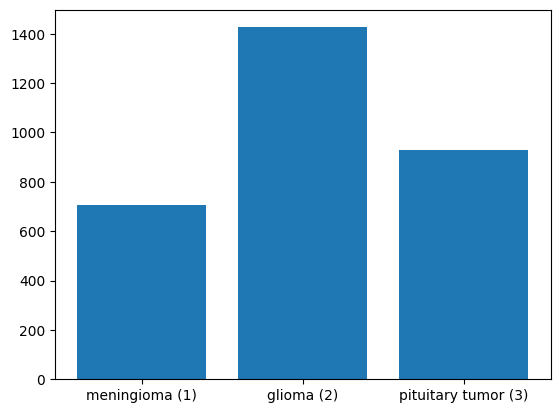

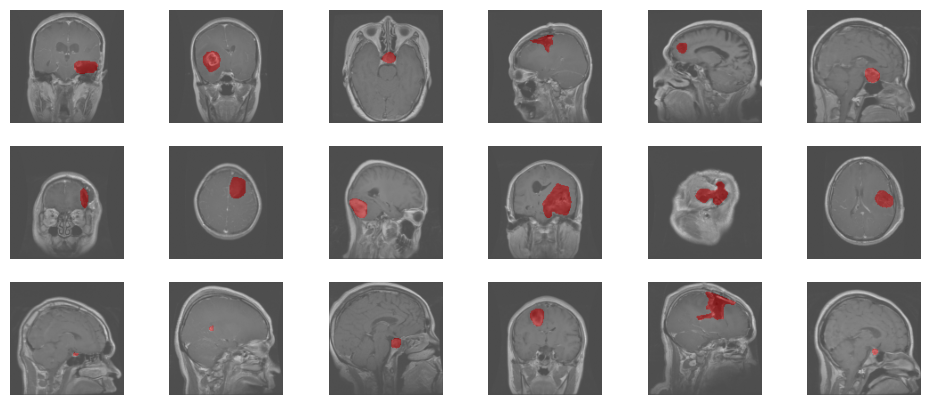

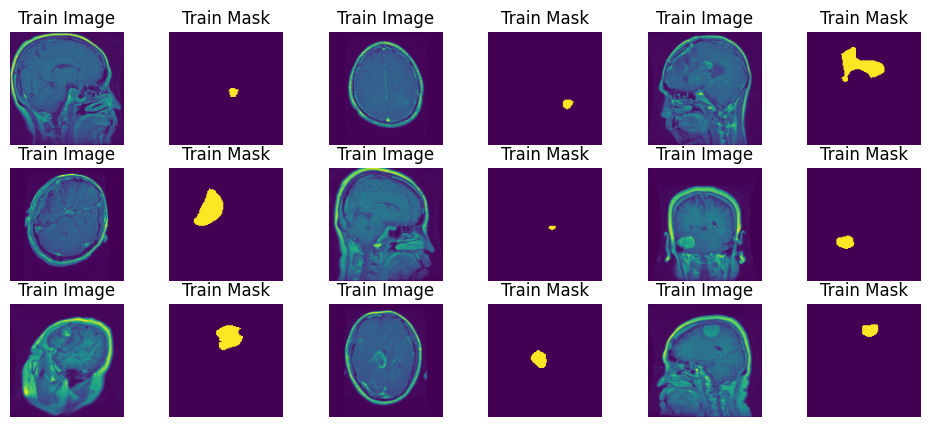

In [ ]:
disp()

In [ ]:
#############2222222222ok#####################
!pip install git+https://github.com/patrick-kidger/torchcubicspline.git


  Cloning https://github.com/patrick-kidger/torchcubicspline.git to /tmp/pip-req-build-xgwtrc1e
  Running command git clone --filter=blob:none --quiet https://github.com/patrick-kidger/torchcubicspline.git /tmp/pip-req-build-xgwtrc1e
  Resolved https://github.com/patrick-kidger/torchcubicspline.git to commit d16c6bf5b63d03dbf2977c70e19a320653b5e4a8
  Preparing metadata (setup.py) ... done


In [ ]:
##########33333333333ok############
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline
import torchcubicspline
print(dir(torchcubicspline))

['NaturalCubicSpline', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'interpolate', 'misc', 'natural_cubic_spline_coeffs']


In [ ]:
##########4444444ok###############
import torch
import torch.nn as nn
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

class SplineActivation(nn.Module):
    """Spline-based activation function for smooth feature recalibration."""
    def __init__(self, in_features, num_knots=15):
        super(SplineActivation, self).__init__()
        self.knots = nn.Parameter(torch.linspace(-1, 1, num_knots))
        self.values = nn.Parameter(torch.rand(num_knots, 1))

    def forward(self, x):
        coeffs = natural_cubic_spline_coeffs(self.knots, self.values)
        spline = NaturalCubicSpline(coeffs, self.knots)
        return spline.evaluate(x)
    def forward(self, x):
        coeffs = natural_cubic_spline_coeffs(self.knots, self.values) # self.values is now (num_knots, 1)
        spline = NaturalCubicSpline(coeffs, self.knots)
        return spline.evaluate(x)

class KolmogorovArnoldNetwork(nn.Module):
    """KAN-based recalibration with optimized spline activation."""
    def __init__(self, in_channels, reduction=8):
        super(KolmogorovArnoldNetwork, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.psi_layers = nn.ModuleList([nn.Linear(in_channels, in_channels // reduction) for _ in range(3)])

#        self.psi_layers = nn.ModuleList([nn.Linear(in_channels, in_channels // reduction) for _ in range(3)])
        self.spline_activation = KANSplineActivation(in_features=in_channels // reduction) # Use a new class
        self.phi_layer = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        x_pooled = self.global_avg_pool(x).view(batch_size, channels)
        kan_out = sum(psi(x_pooled) for psi in self.psi_layers)
        kan_out = self.spline_activation(kan_out)
        kan_out = self.phi_layer(kan_out)
        kan_out = self.sigmoid(kan_out).view(batch_size, channels, 1, 1)
        return x * kan_out.expand_as(x)

# Redefine a SplineActivation suitable for applying a spline per feature (KAN-like)
class KANSplineActivation(nn.Module):
    """Spline-based activation function for smooth feature recalibration, applied per feature."""
    def __init__(self, in_features, num_knots=15):
        super(KANSplineActivation, self).__init__()
        self.in_features = in_features
        self.num_knots = num_knots
        self.knots = nn.Parameter(torch.linspace(-1, 1, num_knots))
        self.values = nn.Parameter(torch.rand(num_knots, in_features))

    def forward(self, x):
        coeffs = natural_cubic_spline_coeffs(self.knots, self.values)
        spline = NaturalCubicSpline(coeffs, self.knots)
        return spline.evaluate(x)


# %%
import torch
import torch.nn as nn
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

# Redefine SplineActivation for KAN-like per-feature application
class KANSplineActivation(nn.Module):
    """Spline-based activation function for smooth feature recalibration, applied per feature."""
    def __init__(self, in_features, num_knots=15):
        super(KANSplineActivation, self).__init__()
        self.in_features = in_features
        self.num_knots = num_knots
        self.knots = nn.Parameter(torch.linspace(-1, 1, num_knots))
        self.values = nn.Parameter(torch.rand(num_knots, in_features))

    def forward(self, x):
        coeffs = natural_cubic_spline_coeffs(self.knots, self.values)
        spline = NaturalCubicSpline(coeffs)
        return spline.evaluate(x)


class KolmogorovArnoldNetwork(nn.Module):
    """KAN-based recalibration with optimized spline activation."""
    def __init__(self, in_channels, reduction=8):
        super(KolmogorovArnoldNetwork, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.psi_layers = nn.ModuleList([nn.Linear(in_channels, in_channels // reduction) for _ in range(3)])
        self.spline_activation = KANSplineActivation(in_features=in_channels // reduction)
        self.phi_layer = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        x_pooled = self.global_avg_pool(x).view(batch_size, channels)
        kan_out = sum(psi(x_pooled) for psi in self.psi_layers)
        kan_out = self.spline_activation(kan_out)
        kan_out = self.phi_layer(kan_out)
        kan_out = self.sigmoid(kan_out)
        kan_out = kan_out.view(batch_size, channels, -1).mean(dim=2).view(batch_size, channels, 1, 1)
        return x * kan_out.expand_as(x)

# %%
class DoubleConv(nn.Module):
    """Two Convolution Layers followed by BatchNorm & ReLU"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            KolmogorovArnoldNetwork(out_channels)  # KAN-enhanced recalibration
        )

    def forward(self, x):
        return self.conv(x)

class KanUNet(nn.Module):
    """U-Net with KAN-enhanced SE block"""
    def __init__(self, in_channels=1, out_channels=1): # Change in_channels from 3 to 1
        super(KanUNet, self).__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.bottleneck = DoubleConv(512, 1024)

        self.dec4 = DoubleConv(1024, 512)
        self.dec3 = DoubleConv(512, 256)
        self.dec2 = DoubleConv(256, 128)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # The forward method remains the same
        enc1 = self.enc1(x)
        import torch.nn.functional as F
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.dec4(F.interpolate(bottleneck, scale_factor=2, mode='nearest'))
        dec3 = self.dec3(F.interpolate(dec4 + enc4, scale_factor=2, mode='nearest'))
        dec2 = self.dec2(F.interpolate(dec3 + enc3, scale_factor=2, mode='nearest'))
        dec1 = self.dec1(F.interpolate(dec2 + enc2, scale_factor=2, mode='nearest'))

        return self.final(F.interpolate(dec1 + enc1, scale_factor=2, mode='nearest'))

# %%
import torch.optim as optim
import torch.nn.functional as F # Import F

def dice_coeff(pred, target):
    """Computes Dice Coefficient for segmentation."""
    # Ensure pred and target are the same shape and type
    pred = pred.float().view(-1)
    target = target.float().view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8) # Add epsilon for stability

def iou_score(pred, target):
    """Computes IoU (Intersection over Union)."""
    # Ensure pred and target are the same shape and type
    pred = pred.float().view(-1)
    target = target.float().view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + 1e-8) # Add epsilon for stability

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score



In [ ]:
##############55555555555ok#################

def plot_metrics_vs_epochs(metrics_history):
    epochs = list(range(1, len(metrics_history["Train Loss"]) + 1))
    metric_names = list(metrics_history.keys())
    colors = ['blue', 'red', 'orange', 'green', 'purple', 'brown', 'magenta']

    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(metric_names):
        plt.subplot(4, 2, i + 1)
        plt.plot(epochs, metrics_history[metric], marker='o', color=colors[i % len(colors)])
        plt.title(f"{metric} vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
########66666666666ok####################
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score

def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    model.to(device)

    # History dictionary to track metrics per epoch
    metrics_history = {
        "Train Loss": [],
        "Val Loss": [],
        "Dice Score": [],
        "IoU": [],
        "Accuracy": [],
        "Precision": [],
        "F1 Score": []
    }

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)

            # Match sizes
            masks_resized = F.interpolate(masks, size=outputs.shape[2:], mode="nearest")
            loss = criterion(outputs, masks_resized.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)

        # Evaluate on validation set
        val_metrics = evaluate_model(model, val_loader, device, criterion)

        # Log all metrics
        metrics_history["Train Loss"].append(avg_train_loss)
        metrics_history["Val Loss"].append(val_metrics["Loss"])
        metrics_history["Dice Score"].append(val_metrics["Dice Score"])
        metrics_history["IoU"].append(val_metrics["IoU"])
        metrics_history["Accuracy"].append(val_metrics["Accuracy"])
        metrics_history["Precision"].append(val_metrics["Precision"])
        metrics_history["F1 Score"].append(val_metrics["F1 Score"])

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {val_metrics['Loss']:.4f} | "
              f"Dice: {val_metrics['Dice Score']:.4f} | IoU: {val_metrics['IoU']:.4f}")

    # Plot metrics vs. epoch
    plot_metrics_vs_epochs(metrics_history)
    return metrics_history


In [ ]:
##############77777777777ok################
def evaluate_model(model, val_loader, device, criterion):
    model.eval()
    dice_scores, iou_scores = [], []
    losses, accuracies, precisions, f1_scores = [], [], [], []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            if masks.ndim == 3:
                masks = masks.unsqueeze(1)

            outputs = model(images)
            preds_probs = torch.sigmoid(outputs)
            preds = preds_probs > 0.5
            preds = preds.float()

            if preds.shape[2:] != masks.shape[2:]:
                preds = F.interpolate(preds, size=masks.shape[2:], mode='nearest')
                preds_probs = F.interpolate(preds_probs, size=masks.shape[2:], mode='nearest')

            loss = criterion(preds_probs, masks.float()).item()
            dice = dice_coeff(preds, masks).item()
            iou = iou_score(preds, masks).item()

            preds_np = preds.cpu().numpy().flatten()
            masks_np = masks.cpu().numpy().flatten()

            acc = accuracy_score(masks_np, preds_np)
            prec = precision_score(masks_np, preds_np, zero_division=0)
            f1 = f1_score(masks_np, preds_np, zero_division=0)

            losses.append(loss)
            dice_scores.append(dice)
            iou_scores.append(iou)
            accuracies.append(acc)
            precisions.append(prec)
            f1_scores.append(f1)

    return {
        "Loss": sum(losses) / len(losses),
        "Dice Score": sum(dice_scores) / len(dice_scores),
        "IoU": sum(iou_scores) / len(iou_scores),
        "Accuracy": sum(accuracies) / len(accuracies),
        "Precision": sum(precisions) / len(precisions),
        "F1 Score": sum(f1_scores) / len(f1_scores),
    }


In [ ]:
###########88888888888ok#########
def plot_metrics_vs_epochs(metrics_history):
    epochs = list(range(1, len(metrics_history["Train Loss"]) + 1))
    metric_names = list(metrics_history.keys())
    colors = ['blue', 'red', 'orange', 'green', 'purple', 'brown', 'magenta']

    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(metric_names):
        plt.subplot(4, 2, i + 1)
        plt.plot(epochs, metrics_history[metric], marker='o', color=colors[i % len(colors)])
        plt.title(f"{metric} vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
###########9999999999ok###########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KanUNet()
metrics_history1=train_model(model, train_loader, val_loader, device, epochs=50, lr=1e-4)


Epoch 1/50 - Train Loss: 0.2354 | Val Loss: 0.7339 | Dice: 0.4366 | IoU: 0.2885
Epoch 2/50 - Train Loss: 0.0669 | Val Loss: 0.7026 | Dice: 0.6288 | IoU: 0.4683
Epoch 3/50 - Train Loss: 0.0355 | Val Loss: 0.6969 | Dice: 0.7225 | IoU: 0.5725
Epoch 4/50 - Train Loss: 0.0264 | Val Loss: 0.6932 | Dice: 0.7582 | IoU: 0.6186
Epoch 5/50 - Train Loss: 0.0212 | Val Loss: 0.6922 | Dice: 0.8024 | IoU: 0.6749
Epoch 6/50 - Train Loss: 0.0185 | Val Loss: 0.6919 | Dice: 0.8204 | IoU: 0.7002
Epoch 7/50 - Train Loss: 0.0165 | Val Loss: 0.6904 | Dice: 0.8386 | IoU: 0.7260
Epoch 8/50 - Train Loss: 0.0142 | Val Loss: 0.6899 | Dice: 0.8505 | IoU: 0.7432
Epoch 9/50 - Train Loss: 0.0130 | Val Loss: 0.6903 | Dice: 0.8708 | IoU: 0.7734
Epoch 10/50 - Train Loss: 0.0118 | Val Loss: 0.6897 | Dice: 0.8567 | IoU: 0.7524
Epoch 11/50 - Train Loss: 0.0119 | Val Loss: 0.6894 | Dice: 0.8723 | IoU: 0.7759
Epoch 12/50 - Train Loss: 0.0101 | Val Loss: 0.6892 | Dice: 0.8909 | IoU: 0.8049
Epoch 13/50 - Train Loss: 0.0099 | Va

In [ ]:
import pickle

# Save the model state_dict
torch.save(model.state_dict(), 'kanunet_model.pth')

# Save the training history (metrics_history2) using pickle
with open('metrics_history1.pkl', 'wb') as f:
    pickle.dump(metrics_history1, f)

In [ ]:
import torch
import pickle

# Recreate the model architecture
model = KanUNet()
model.load_state_dict(torch.load('kanunet_model.pth'))
model.to(device)
#      model.eval()  # set to evaluation mode if you're evaluating/inferencing

# Load the training history
with open('metrics_history1.pkl', 'rb') as f:
    metrics_history1 = pickle.load(f)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [ ]:
with open('metrics_history1.pkl', 'rb') as f:
    metrics_history1 = pickle.load(f)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DoubleConvSe(nn.Module):
    """Two Convolution Layers followed by BatchNorm & ReLU + SEBlock"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConvSe, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)  # SE block instead of KAN
        )

    def forward(self, x):
        return self.conv(x)

class SEUNet(nn.Module):
    """U-Net with SE blocks instead of KAN"""
    def __init__(self, in_channels=1, out_channels=1): # Change in_channels from 3 to 1
        super(SEUNet, self).__init__()

        self.enc1 = DoubleConvSe(in_channels, 64)
        self.enc2 = DoubleConvSe(64, 128)
        self.enc3 = DoubleConvSe(128, 256)
        self.enc4 = DoubleConvSe(256, 512)

        self.bottleneck = DoubleConvSe(512, 1024)

        self.dec4 = DoubleConvSe(1024, 512)
        self.dec3 = DoubleConv(512, 256) # This uses DoubleConv, ensure its first layer is correct
        self.dec2 = DoubleConvSe(256, 128)
        self.dec1 = DoubleConvSe(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # The forward method remains the same
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.dec4(F.interpolate(bottleneck, scale_factor=2, mode='nearest'))
        dec3 = self.dec3(F.interpolate(dec4 + enc4, scale_factor=2, mode='nearest'))
        dec2 = self.dec2(F.interpolate(dec3 + enc3, scale_factor=2, mode='nearest'))
        dec1 = self.dec1(F.interpolate(dec2 + enc2, scale_factor=2, mode='nearest'))

        return self.final(F.interpolate(dec1 + enc1, scale_factor=2, mode='nearest'))

Epoch 1/50 - Train Loss: 0.2190 | Val Loss: 0.7349 | Dice: 0.4990 | IoU: 0.3412
Epoch 2/50 - Train Loss: 0.0687 | Val Loss: 0.7022 | Dice: 0.5557 | IoU: 0.3966
Epoch 3/50 - Train Loss: 0.0370 | Val Loss: 0.6960 | Dice: 0.6728 | IoU: 0.5174
Epoch 4/50 - Train Loss: 0.0269 | Val Loss: 0.6952 | Dice: 0.7509 | IoU: 0.6072
Epoch 5/50 - Train Loss: 0.0218 | Val Loss: 0.6928 | Dice: 0.8013 | IoU: 0.6737
Epoch 6/50 - Train Loss: 0.0187 | Val Loss: 0.6910 | Dice: 0.8135 | IoU: 0.6903
Epoch 7/50 - Train Loss: 0.0159 | Val Loss: 0.6907 | Dice: 0.8434 | IoU: 0.7327
Epoch 8/50 - Train Loss: 0.0147 | Val Loss: 0.6902 | Dice: 0.8535 | IoU: 0.7475
Epoch 9/50 - Train Loss: 0.0124 | Val Loss: 0.6902 | Dice: 0.8503 | IoU: 0.7428
Epoch 10/50 - Train Loss: 0.0115 | Val Loss: 0.6896 | Dice: 0.8757 | IoU: 0.7810
Epoch 11/50 - Train Loss: 0.0110 | Val Loss: 0.6894 | Dice: 0.8739 | IoU: 0.7781
Epoch 12/50 - Train Loss: 0.0104 | Val Loss: 0.6892 | Dice: 0.8791 | IoU: 0.7868
Epoch 13/50 - Train Loss: 0.0092 | Va

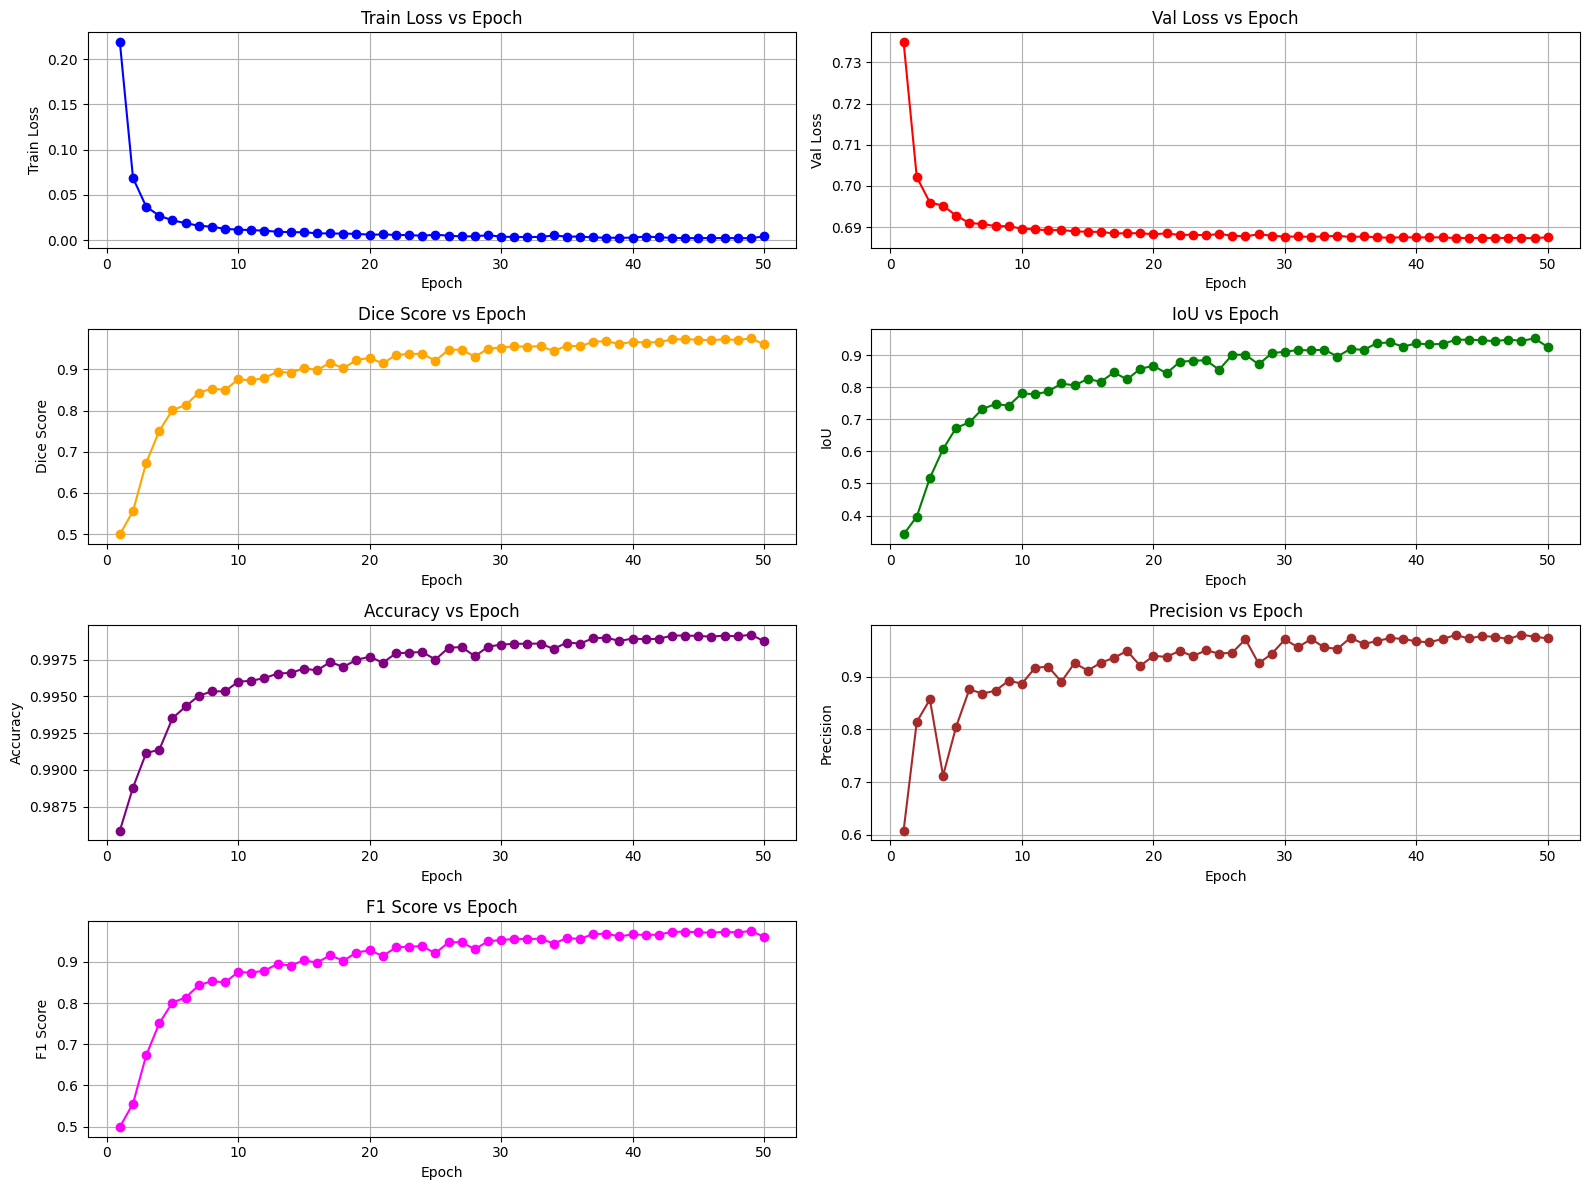

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SEUNet()
metrics_history2=train_model(model, train_loader, val_loader, device, epochs=50, lr=1e-4)

In [ ]:
import pickle

# Save the model state_dict
torch.save(model.state_dict(), 'seunet_model.pth')

# Save the training history (metrics_history2) using pickle
with open('metrics_history2.pkl', 'wb') as f:
    pickle.dump(metrics_history2, f)

In [ ]:
import torch
import pickle

# Recreate the model architecture
model = SEUNet()
model.load_state_dict(torch.load('seunet_model.pth'))
model.to(device)
#      model.eval()  # set to evaluation mode if you're evaluating/inferencing

# Load the training history
with open('metrics_history2.pkl', 'rb') as f:
    metrics_history2 = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt

def compare_models_metrics_vs_epochs(metrics_model1, metrics_model2, labels=("Model 1", "Model 2")):
    epochs = list(range(1, len(next(iter(metrics_model1.values()))) + 1))
    metric_names = metrics_model1.keys()
    colors = ['blue', 'red', 'orange', 'green', 'purple', 'brown', 'magenta']

    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(metric_names):
        plt.subplot(4, 2, i + 1)
        plt.plot(epochs, metrics_model1[metric], marker='o', color=colors[i % len(colors)], label=labels[0])
        plt.plot(epochs, metrics_model2[metric], marker='s', linestyle='--', color=colors[(i + 1) % len(colors)], label=labels[1])

        plt.title(f"{metric} vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

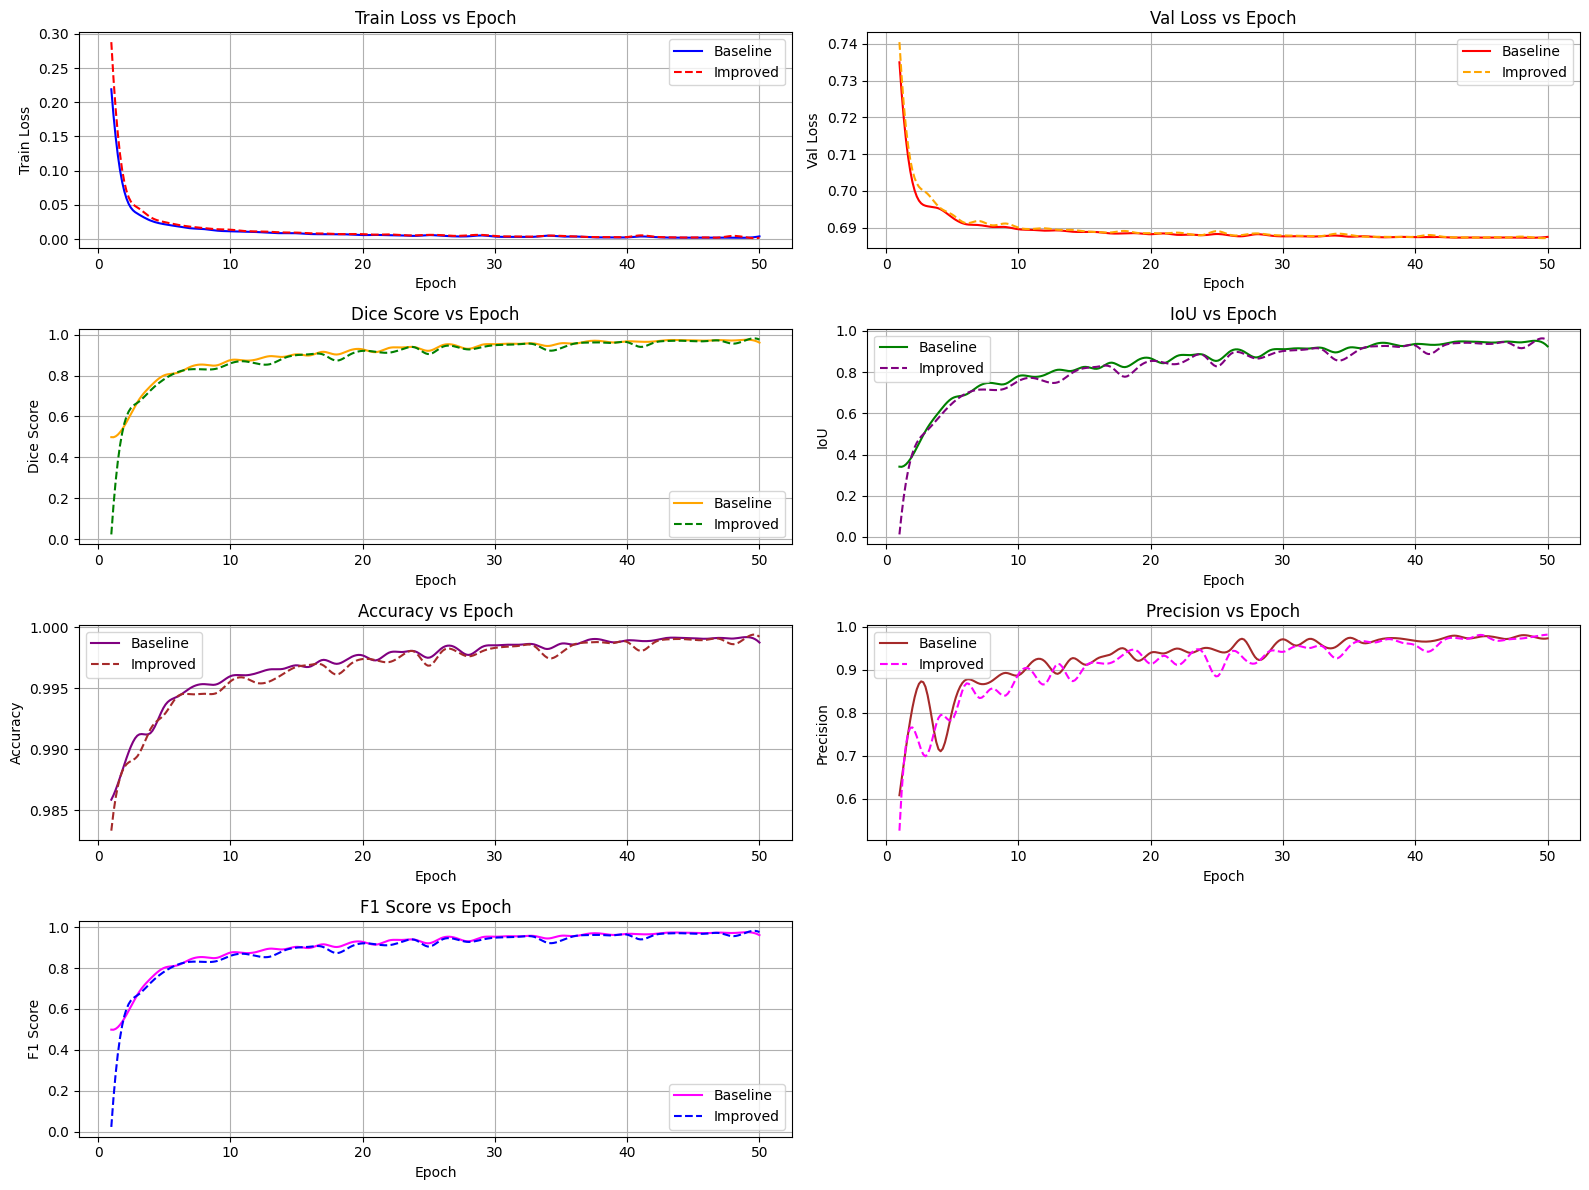

In [ ]:
compare_models_metrics_vs_epochs(metrics_history2, metrics_history1, labels=("Baseline", "Improved"))

In [ ]:
!pip install scipy


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

def smooth_line(x, y, points=300):
    x_new = np.linspace(min(x), max(x), points)
    spline = make_interp_spline(x, y, k=3)  # Cubic spline
    y_new = spline(x_new)
    return x_new, y_new

def compare_models_metrics_vs_epochs(metrics_model1, metrics_model2, labels=("Model 1", "Model 2")):
    epochs = list(range(1, len(next(iter(metrics_model1.values()))) + 1))
    metric_names = metrics_model1.keys()
    colors = ['blue', 'red', 'orange', 'green', 'purple', 'brown', 'magenta']

    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(metric_names):
        plt.subplot(4, 2, i + 1)

        x1_smooth, y1_smooth = smooth_line(epochs, metrics_model1[metric])
        x2_smooth, y2_smooth = smooth_line(epochs, metrics_model2[metric])

        plt.plot(x1_smooth, y1_smooth, color=colors[i % len(colors)], label=labels[0])
        plt.plot(x2_smooth, y2_smooth, linestyle='--', color=colors[(i + 1) % len(colors)], label=labels[1])

        plt.title(f"{metric} vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()


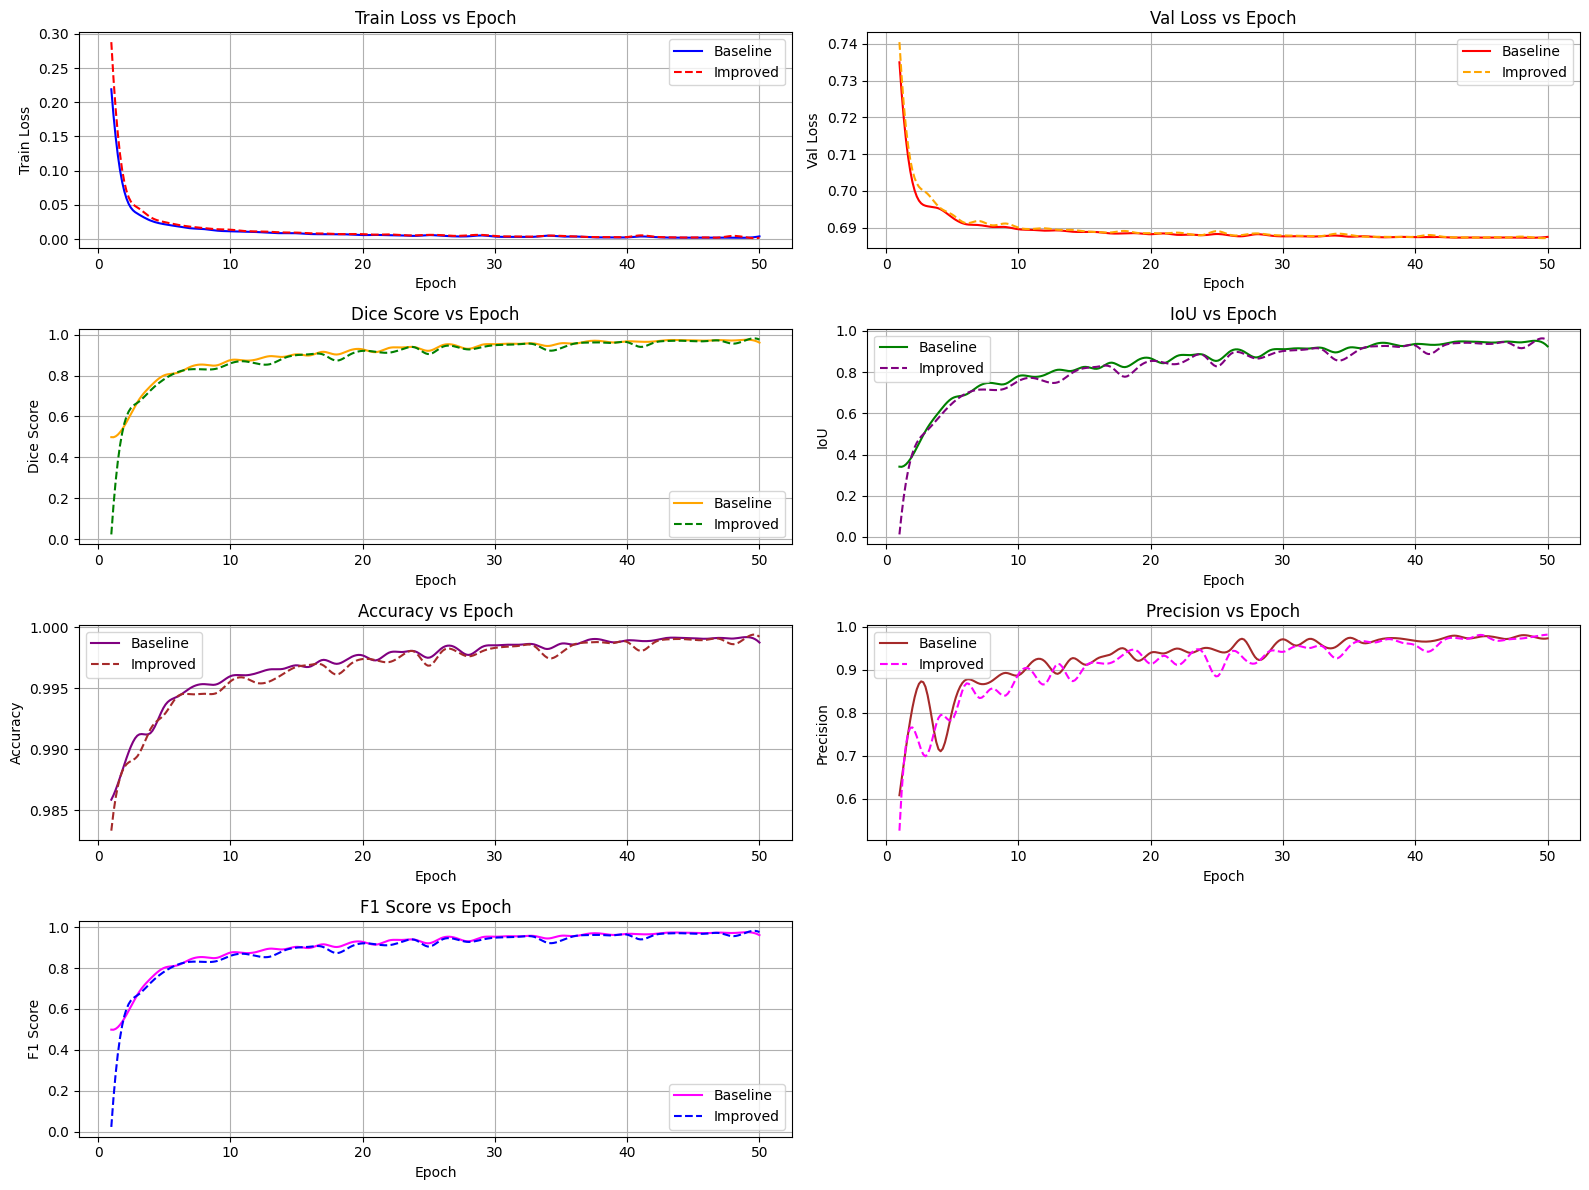

In [ ]:
compare_models_metrics_vs_epochs(metrics_history2, metrics_history1, labels=("Baseline", "Improved"))